## I Introduction


- Specificity of data: censored data with outcome variable (time until an event occurs)
- Survival analysis application examples: hardware failure, customer subscription, product analytics: time to adoption, unit economics: time to break-even revenue, clinical research ect.
- The goal of this analysis: to reviewed the survival time for patients with brain tumors undergoing radiation treatment, identify risk factors and characteristics and describe their influence on survival time, and built a model to forecast survival time, enabling more effective risk assessment and resource allocation for brain cancer patients. 

In [ ]:
# Prepare libraries
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['figure.figsize'] = [7.5, 4.5]
plt.rcParams['figure.dpi'] = 100
import seaborn as sns
sns.set_style(style='darkgrid', rc={'axes.facecolor': '.9', 'grid.color': '.8'})
sns.set_palette(palette='deep')

import numpy as np
import pandas as pd

import warnings                       
warnings.simplefilter (action = 'ignore')

In [2]:
from lifelines import (KaplanMeierFitter, CoxPHFitter)
from lifelines.utils import (median_survival_times, concordance_index)
from lifelines.plotting import plot_lifetimes
from lifelines.calibration import survival_probability_calibration
from lifelines.statistics import (logrank_test, multivariate_logrank_test,proportional_hazard_test)

In [3]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.calibration import calibration_curve 
from sklearn.metrics import brier_score_loss

from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

from ISLP import load_data

## II Read and understand the Data

In [4]:
BrainCancer = load_data('BrainCancer')
df=BrainCancer.copy()
df.head()

,sex,diagnosis,loc,ki,gtv,stereo,status,time
0,Female,Meningioma,Infratentorial,90,6.11,SRS,0,57.64
1,Male,HG glioma,Supratentorial,90,19.35,SRT,1,8.98
2,Female,Meningioma,Infratentorial,70,7.95,SRS,0,26.46
3,Female,LG glioma,Supratentorial,80,7.61,SRT,1,47.80
4,Male,HG glioma,Supratentorial,90,5.06,SRT,1,6.30


In [5]:
df.columns

Index(['sex', 'diagnosis', 'loc', 'ki', 'gtv', 'stereo', 'status', 'time'], dtype='object')

In [ ]:
df.shape

(88, 8)

Insights:
- The column of interest is time (survival time), in months. 
- The variable status: indicates whether the observation is censored or still alive at the end of the study: 0=Yes, 1=No.
- The other variables are additional covariates:
sex: Female/Male
diagnosis: Meningioma, LG glioma, HG glioma, and Other  
loc: Location, Infratentorial/Supratentorial.
ki: Karnofsky Performance Status (health evaluation)
gtv: Gross tumor volume, in cm3.
stereo: SRS SRT, stereotactic radiotherapy/radiosurgery

## III Data quality check, clean, fill

In [7]:
df.info()
# 1 NA, 4 category features. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   sex        88 non-null     category
 1   diagnosis  87 non-null     category
 2   loc        88 non-null     category
 3   ki         88 non-null     int64   
 4   gtv        88 non-null     float64 
 5   stereo     88 non-null     category
 6   status     88 non-null     int64   
 7   time       88 non-null     float64 
dtypes: category(4), float64(2), int64(2)
memory usage: 3.8 KB


In [8]:
df.isna().sum()

sex          0
diagnosis    1
loc          0
ki           0
gtv          0
stereo       0
status       0
time         0
dtype: int64

In [5]:
# Fill NA with the first mode
df['diagnosis'].fillna(df['diagnosis'].mode()[0], inplace=True)

In [173]:
df.isna().sum()

sex          0
diagnosis    0
loc          0
ki           0
gtv          0
stereo       0
status       0
time         0
dtype: int64

In [11]:
df=df.drop_duplicates()
df.shape
# No duplicates

(88, 8)

## IV Explore features

In [140]:
# Numerical features
num_cols=['ki', 'gtv', 'time']
df[num_cols].describe()

,ki,gtv,time
count,88.000000,88.000000,88.000000
mean,81.022727,8.660795,27.457500
std,10.508866,8.657576,20.124412
min,40.000000,0.010000,0.070000
25%,80.000000,2.500000,10.392500
50%,80.000000,6.510000,24.030000
75%,90.000000,12.100000,41.597500
max,100.000000,34.640000,82.560000


Insights:
- Time: max~83 months, min~0.07, mean~27.5, mean>median, std~20. slightly right skew.
- ki: max~100, min~40, mean~81, std~10,mean~median. 
- gtv: max~35, min~0.01, mean~8.6, std~8, mean~median.
- scales of numerical features are not significant, therefore scale precessing is not performed.  

In [ ]:
# Categorical features
cat_cols=['sex', 'diagnosis', 'loc','stereo', 'status']
for i in cat_cols:
    print(df[i].value_counts(),'\n')

Female    45
Male      43
Name: sex, dtype: int64 

Meningioma    43
HG glioma     22
Other         14
LG glioma      9
Name: diagnosis, dtype: int64 

Supratentorial    69
Infratentorial    19
Name: loc, dtype: int64 

SRT    65
SRS    23
Name: stereo, dtype: int64 

0    53
1    35
Name: status, dtype: int64 



In [145]:
for i in cat_cols:
    print(df.groupby([i,'status'])['time'].count(),'\n')
    (print('-----------------------------'))

sex     status
Female  0         30
        1         15
Male    0         23
        1         20
Name: time, dtype: int64 

-------------------------------------------
diagnosis   status
HG glioma   0          5
            1         17
LG glioma   0          5
            1          4
Meningioma  0         34
            1          9
Other       0          9
            1          5
Name: time, dtype: int64 

-------------------------------------------
loc             status
Infratentorial  0         15
                1          4
Supratentorial  0         38
                1         31
Name: time, dtype: int64 

-------------------------------------------
stereo  status
SRS     0         18
        1          5
SRT     0         35
        1         30
Name: time, dtype: int64 

-------------------------------------------
status  status
0       0         53
1       1         35
Name: time, dtype: int64 

-------------------------------------------


Insights:
- 'Status' is the Target feature. 35 patients were dead, 53 were alive or censored. There are only 35 observations with status 1 (event observed), i.e 40% of the total data. 
- 'diagnosis' has 4 levels. Meningioma is the main type. The others have 2 levels respectively. Among dead patients (35), 17 patients had HG glioma.
- The numbers of female and male are almost identical.
- 'Supratentorial' is the principle location. Among dead patients (35), 31 patients had 'Supratentorial'.
- Most of the patients received SRT therapy. Among dead patients (35), 30 patients were under SRT therapy.

Do some plots to visualize these observations as following.

[Text(0.5, 0, 'Months'),
 Text(0, 0.5, 'Patient'),
 Text(0.5, 1.0, 'Illustration of censored survival data for 10 patients'),
 (0.0, 85.0)]

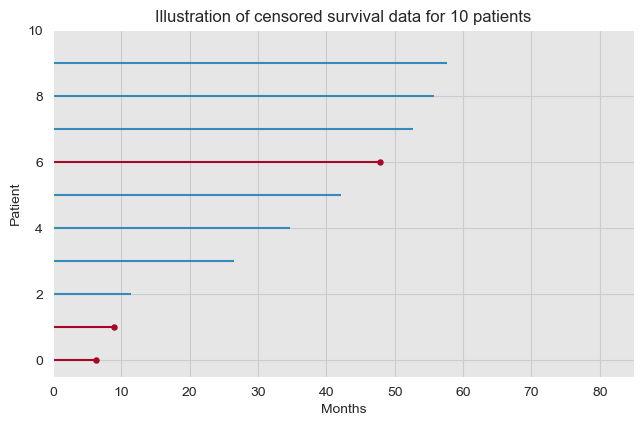

In [ ]:
# Visualize individual patient lifeline
fig, ax = plt.subplots()
plot_lifetimes(df[:10]['time'], df[:10]['status'])
ax.set(xlabel='Months',
       ylabel='Patient',
       title='Illustration of censored survival data for 10 patients',
       xlim=[0,85])

Insights:
plot the lifelines of the first 10 patients. 3 death was observed, 7 patient were dropped out of the study (censored), considering the max month is the deadline of the study (83 months). 

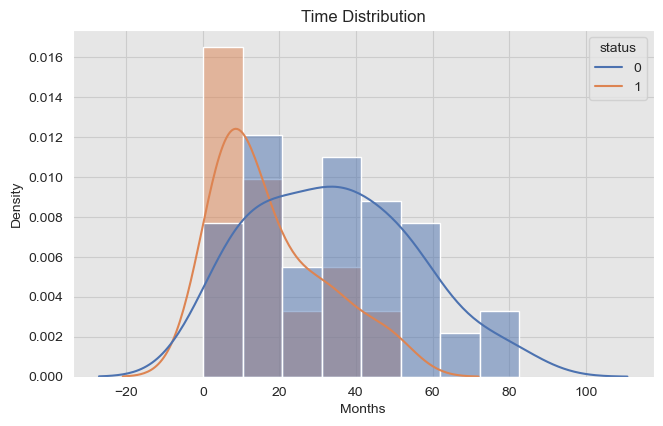

In [ ]:
# Visualize time distribution split by status
fig, ax = plt.subplots()
sns.histplot(data=df,x=df['time'],hue='status', stat='density', ax=ax)
sns.kdeplot(data=df,x=df['time'], hue='status', fill=False, ax=ax)
ax.set(title='Time Distribution',
     xlabel='Months');

Insights:
- Plot the time distribution based on status:  compared to that of censored and alive status 0, the time distribution of the status 1 is more centered with smaller mean time. Among patients died, most of the death happened before 20 months.  Censored and alive status distributed continuously in various time periods between 0 and 80 months.

[Text(0.5, 1.0, 'gtv distribution')]

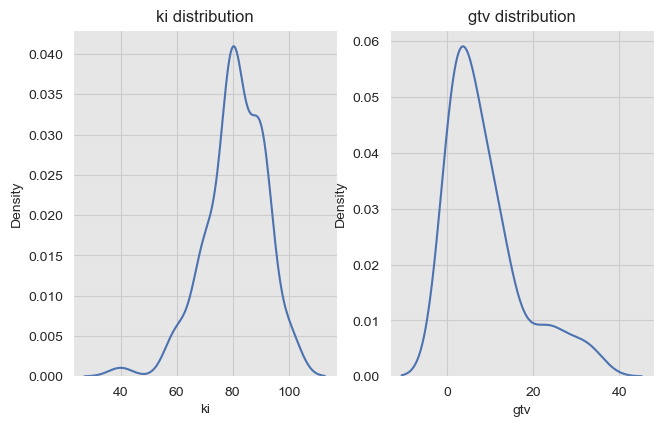

In [ ]:
# Plot ki and gtv distribution
fig,ax=plt.subplots(1,2)
sns.kdeplot(data=df,x='ki',ax=ax[0])
ax[0].set(title='ki distribution')
sns.kdeplot(data=df,x='gtv',ax=ax[1])
ax[1].set(title='gtv distribution')

[Text(0.5, 0, 'Status'), Text(0, 0.5, 'Months'), Text(0.5, 1.0, 'Sex split')]

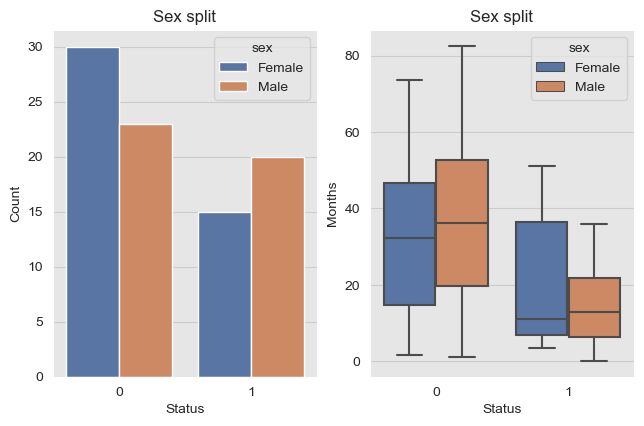

In [147]:
# Compare female and male lifeline
fig,ax=plt.subplots(1,2)
sns.countplot(data=df, x='status', hue='sex', ax=ax[0])
ax[0].set(xlabel='Status', ylabel='Count', title='Sex split')
sns.boxplot(data=df, x='status', y='time', hue='sex', ax=ax[1])
ax[1].set(xlabel='Status', ylabel='Months', title='Sex split')

Insights:
male and female numbers are nearly identical. Il seems that more females survive than males (30 vs 23).
However,from boxplot, slightly longer median lifetime was observed for males. 

[Text(0.5, 0, 'Status'),
 Text(0, 0.5, 'Months'),
 Text(0.5, 1.0, 'Location split')]

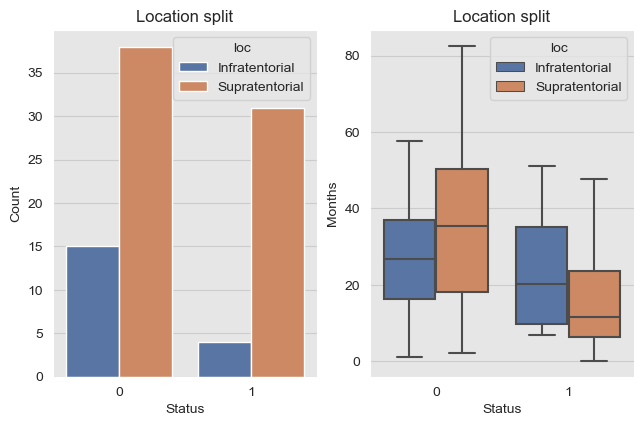

In [146]:
# Compare location
fig,ax=plt.subplots(1,2)
sns.countplot(data=df, x='status', hue='loc', ax=ax[0])
ax[0].set(xlabel='Status', ylabel='Count', title='Location split')
sns.boxplot(data=df, x='status', y='time', hue='loc', ax=ax[1])
ax[1].set(xlabel='Status', ylabel='Months', title='Location split')

[Text(0.5, 0, 'Status'),
 Text(0, 0.5, 'Months'),
 Text(0.5, 1.0, 'Diagnosis split')]

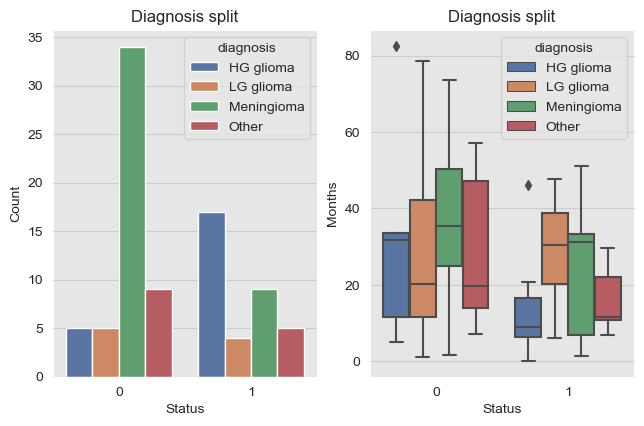

In [148]:
# Compare diagnosis
fig,ax=plt.subplots(1,2)
sns.countplot(data=df, x='status', hue='diagnosis', ax=ax[0])
ax[0].set(xlabel='Status', ylabel='Count', title='Diagnosis split')
sns.boxplot(data=df, x='status', y='time', hue='diagnosis', ax=ax[1])
ax[1].set(xlabel='Status', ylabel='Months', title='Diagnosis split')

[Text(0.5, 0, 'Status'),
 Text(0, 0.5, 'Months'),
 Text(0.5, 1.0, 'Therapy split')]

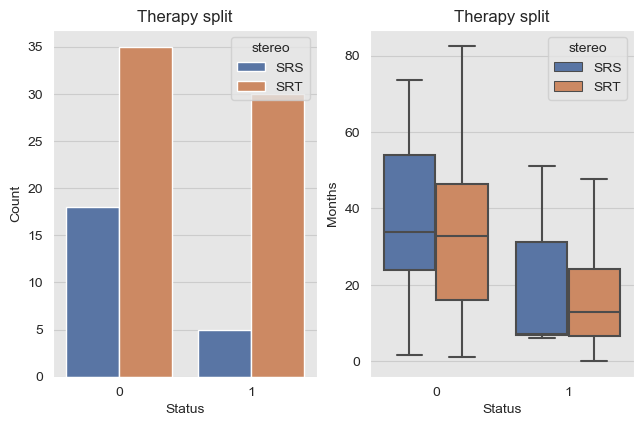

In [149]:
# Compare therapy
fig,ax=plt.subplots(1,2)
sns.countplot(data=df, x='status', hue='stereo', ax=ax[0])
ax[0].set(xlabel='Status', ylabel='Count', title='Therapy split')
sns.boxplot(data=df, x='status', y='time', hue='stereo', ax=ax[1])
ax[1].set(xlabel='Status', ylabel='Months', title='Therapy split')

In [52]:
# Create dummies 
df1=pd.get_dummies(df, drop_first=True)
df1.head()

,ki,gtv,status,time,sex_Male,diagnosis_LG glioma,diagnosis_Meningioma,diagnosis_Other,loc_Supratentorial,stereo_SRT
0,90,6.11,0,57.64,0,0,1,0,0,0
1,90,19.35,1,8.98,1,0,0,0,1,1
2,70,7.95,0,26.46,0,0,1,0,0,0
3,80,7.61,1,47.80,0,1,0,0,1,1
4,90,5.06,1,6.30,1,0,0,0,1,1


In [54]:
# Space in the name can lead to bug, so change the name 
df1=df1.rename(columns={'diagnosis_LG glioma':'diagnosis_LG_glioma'})

## V Create Kaplan-Meier survival curves

V.1 Kaplan-Meier survival analysis for the whole groupe

In [89]:
# Survival probability S(t)
km=KaplanMeierFitter()
km_brain=km.fit(durations=df['time'], event_observed=df['status'])
km_brain.survival_function_

,KM_estimate
timeline,
0.00,1.000000
0.07,0.988636
1.18,0.988636
1.41,0.977141
1.54,0.977141
...,...
65.02,0.451543
67.38,0.451543
73.74,0.451543


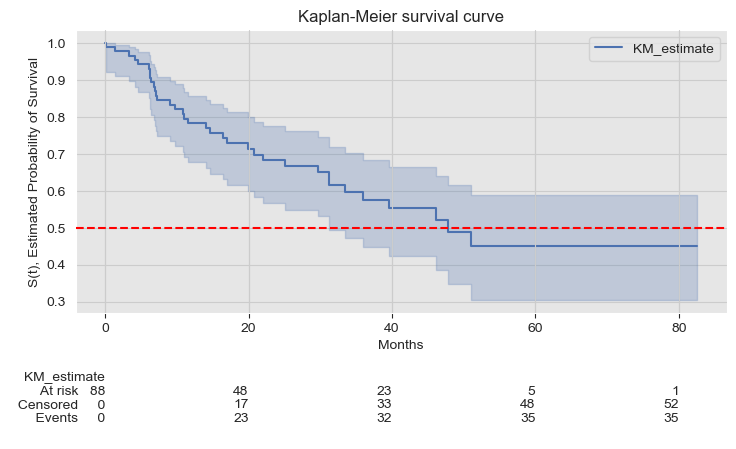

In [90]:
fig, ax = plt.subplots()
km_brain.plot_survival_function(at_risk_counts=True,color='C0',ax=ax) 
ax.set(title='Kaplan-Meier survival curve',
       xlabel='Months',
       ylabel='S(t), Estimated Probability of Survival');
plt.axhline(y=0.5, color='r', ls='--')

In [95]:
median_time = km.median_survival_time_
median_time_confidence_interval= median_survival_times(km.confidence_interval_)
print (f'The median time is {median_time}')
median_time_confidence_interval

The median time is 47.8


,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.5,31.25,inf


Insights: Kaplan_meier survival curve (estimated survival function):
- for the time point 20 months, 23 people dead, 17 people censored (status=0 and time <20), 48 people continued (status=0 and time >20); 35 patients died before the end of the study and 53 of 88 were still alive (or censored not related to death).
- Each point in the step-like curve shows the estimated probability of surviving past the time indicated on the horizontal axis. The estimated probability of survival past 20 months is about 71%. 50% of the population is alive at 48 month.
- Blue bands: default confidence interval 95%, (can be changed by setting alpha)

V.2 Compare the survival of males to that of females

for Female, at survival propability 50%, the time is: 51.02 
      Female_lower_0.95  Female_upper_0.95
0.5              39.54                inf
------------------------------
for Male, at survival propability 50%, the time is: 31.25 
      Male_lower_0.95  Male_upper_0.95
0.5             19.9              inf
------------------------------


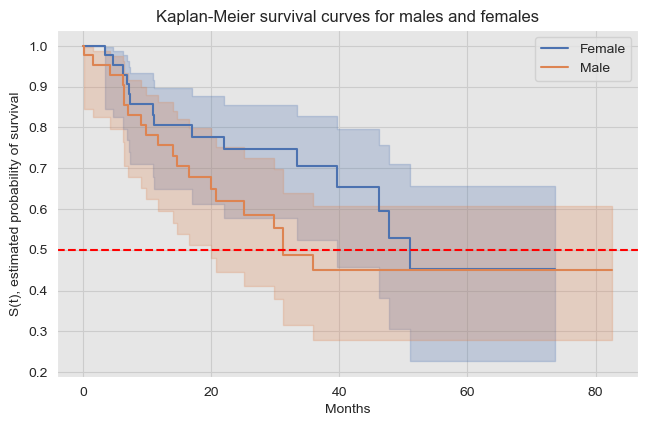

In [67]:
# Plot KM curves stratified by sex. KM analysis can study only one categorical feature. Numerical feature should be stratified into intervals.
km_sex=KaplanMeierFitter()

ax = plt.subplot()
for sex, grouped_df in df.groupby('sex'):
    km_sex.fit(grouped_df['time'], grouped_df['status'], label=sex)
    median_ = km_sex.median_survival_time_
    median_confidence_interval_ = median_survival_times(km_sex.confidence_interval_)
    km_sex.plot_survival_function(ax=ax)
    print(f'For {sex}, at survival propability 50%, the time is: {median_} \n {median_confidence_interval_}') 
    print('------------------------------')

ax.set(title='Kaplan-Meier survival curves for males and females',
       xlabel='Months',
       ylabel='S(t), estimated probability of survival');

plt.axhline(y=0.5, color='r', ls='--')

At survival probability 50% level, females seem to fare a little better up to 50 months, comparing to about 30 months for males. Il seems that females survive for longer than males. But two curves both level off to about 45%. Carry out Logrank test to see weather the two curves are equal.
Why is the CI of median inf? 

In [52]:
# Empty dict to store 2 keys (female and male) and their values
df_sex={}
for sex, grouped_df in df.groupby('sex'):
    df_sex[sex]=grouped_df

In [55]:
logrank_test(durations_A = df_sex['Male']['time'],
             durations_B = df_sex['Female']['time'],
             event_observed_A = df_sex['Male']['status'],
             event_observed_B = df_sex['Female']['status'])

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.44 0.23      2.12

The resulting p-value is 0.23, indicating no significant statistic evidence to reject the H0 hypothesis (group 1 = group 2), i.e, the test indicate no evidence of a difference in survival between the two sexes. Since the Kaplan–Meier estimator is limited in its ability to estimate survival adjusted for covariates, next we plug in CoXPH models.

## VI Cox proportional hazard regression model

VI.1 Check EPV

There are 35 observations with status 1 and 7 features. Events per variable (EPV) =35/7=5. The minimax EPV values recommended for proportional hazards regression analysis is 10. The results of proportional hazards regression analyses in this case should be interpreted with caution because the statistical model may not be valid if all 7 features are used. Reducing features dimension is effective solution (par ex. feature selection).

VI.2 Detecting multicollinearity

In [175]:
# VIF check for all features 
df1.columns

Index(['ki', 'gtv', 'status', 'time', 'sex_Male', 'diagnosis_LG glioma',
       'diagnosis_Meningioma', 'diagnosis_Other', 'loc_Supratentorial',
       'stereo_SRT'],
      dtype='object')

In [176]:
# VIF variables set 
X_vif= df1[['ki', 'gtv', 'sex_Male', 'diagnosis_LG glioma',
       'diagnosis_Meningioma', 'diagnosis_Other', 'loc_Supratentorial',
       'stereo_SRT']] 
X_vif=add_constant(X_vif)
  
# Calculating VIF for each feature and store the values in vif_df dataframe
vif_df = pd.DataFrame() 
vif_df['Feature'] = X_vif.columns
vif_df['VIF'] = [variance_inflation_factor(X_vif.values, i) 
                          for i in range(X_vif.shape[1])] 
vif_df['VIF'] = round(vif_df['VIF'], 2)
vif_df = vif_df.sort_values(by = "VIF", ascending = False)
vif_df

,Feature,VIF
0,const,86.39
6,diagnosis_Other,1.76
5,diagnosis_Meningioma,1.68
7,loc_Supratentorial,1.54
8,stereo_SRT,1.40
4,diagnosis_LG glioma,1.28
2,gtv,1.24
1,ki,1.13
3,sex_Male,1.12


Insights: all VIF values are less than 10, indicating there is no serious collinearity between features.
Visualize correlations by heatmap. 

Text(0.5, 1.0, 'Diagonal Correlation HeatMap')

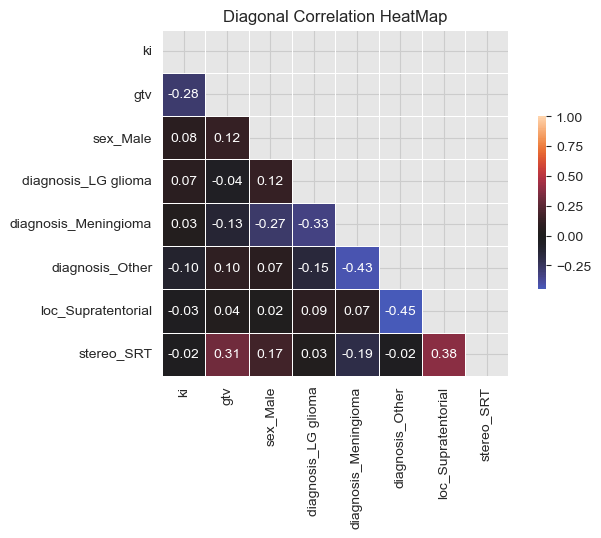

In [177]:
#  Visualize correlation
f, ax = plt.subplots()
corr = X_vif.drop('const', axis=1).corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask,vmax=1, center=0, annot=True, fmt='.2f',\
square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Diagonal Correlation HeatMap")

VI.3 PH model using sex as the only predictor

In [77]:
cph_sex = CoxPHFitter()
cph_sex.fit(df1, duration_col='time', event_col='status',formula='sex_Male')
cph_sex.summary[['coef', 'exp(coef)', 'se(coef)', 'p']]

,coef,exp(coef),se(coef),p
covariate,,,,
sex_Male,0.407668,1.503309,0.342004,0.233262


In [210]:
cph_sex.log_likelihood_ratio_test()

<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           1.44 0.23      2.12

Insights:
Compare this model with the one without features via likelihood ratio method, p value =0.23 is not significant. No matter which test we use (logrank test showed above, loglikelihood ratio test, PH model including only sex feature), we found the same result p value =0.23 : there is no clear evidence for a difference in survival between males and females.

VI.4 Fit a model for each feature to evaluate their effect respectively

In [83]:
cph = CoxPHFitter()
varList=['ki', 'gtv', 'sex_Male', 'diagnosis_LG_glioma','diagnosis_Meningioma', 'diagnosis_Other', 'loc_Supratentorial','stereo_SRT']
for var in varList:
    cph.fit(df1, duration_col='time', event_col='status',formula=var)
    print(f'p-value for {var} is {cph.summary.p[var]:.3f}, < 0.05 {cph.summary.p[var]<0.05}')

p-value for ki is 0.002, < 0.05 True
p-value for gtv is 0.006, < 0.05 True
p-value for sex_Male is 0.233, < 0.05 False
p-value for diagnosis_LG_glioma is 0.855, < 0.05 False
p-value for diagnosis_Meningioma is 0.000, < 0.05 True
p-value for diagnosis_Other is 0.926, < 0.05 False
p-value for loc_Supratentorial is 0.121, < 0.05 False
p-value for stereo_SRT is 0.040, < 0.05 True


Insights: For sex_Male, diagnosis_LG_glioma,diagnosis_Other, loc_Supratentorial, p values are more than 0.05.

VI.5 Fit a full model using all predictors

In [84]:
cph_cox = CoxPHFitter()
cph_cox.fit(df1,duration_col='time', event_col='status')
cph_cox.summary[['coef', 'exp(coef)', 'se(coef)', 'p']]

,coef,exp(coef),se(coef),p
covariate,,,,
ki,-0.055664,0.945857,0.018321,0.002380
gtv,0.034651,1.035258,0.022452,0.122741
sex_Male,0.167841,1.182749,0.359690,0.640766
diagnosis_LG_glioma,-1.233442,0.291288,0.579638,0.033341
diagnosis_Meningioma,-2.187015,0.112251,0.448086,0.000001
diagnosis_Other,-1.280359,0.277938,0.618209,0.038352
loc_Supratentorial,0.433195,1.542177,0.705423,0.539154
stereo_SRT,0.163653,1.177806,0.602026,0.785747


Insights:
- Based on P values, gtv, sex,stereo, loc, these 4 features have no significant effect on hazard rate. 
- In contract, each one unit increase in the Karnofsky index corresponds to a multiplier of exp (-0.05) = 0.95 in the instantaneous chance of dying. In other words, the higher the Karnofsky index, the lower the chance of dying at any given point in time. This effect is highly significant, with a p-value of 0.0016.
- Diagnosis is qualitative with 4 levels: HG glioma, LG glioma, Meningioma, Other. It has been encoded so that the baseline corresponds to HG glioma. The results indicate that the risk associated with HG glioma is more than 8 times (i.e. exp(2.18)=8.8) the risk associated with Meningioma. In other words,  after adjusting for the other predictors, patients with HG glioma have much worse survival compared to those with Meningioma. HG glioma is actually the worse one among 4 levels, since the other three types all have negative coefficients.
- Based on the p values obtained from models of individual feature, sex, stereo and loc features will be removed.

Text(0.5, 1.0, 'Hasard Ratio, i.e. exp(coef)')

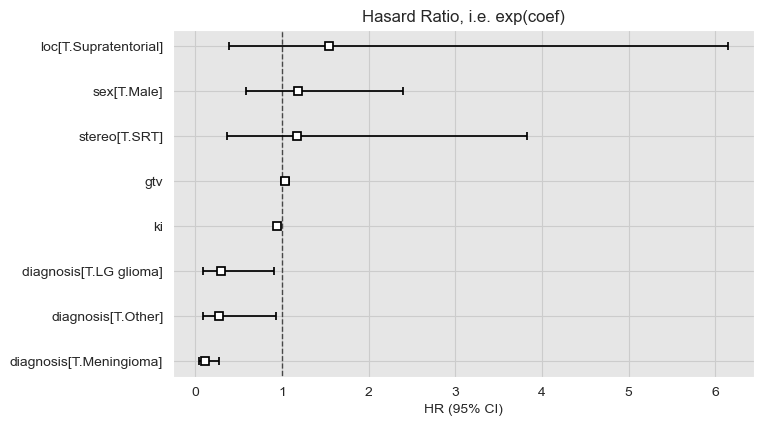

In [35]:
plt.subplots()
cph_cox.plot(hazard_ratios=True)
plt.title('Hazard Ratio, i.e. exp(coef)')
# For features of which 95% CI are far away from x=1, p<0.05

Insights: feature importance visualization: features with Confidence interval far from the dash line (exp1=0) have more significant effect on hazard; in contrast, CI include the dash line (exp1=0) have less evidence. 

VI.6 Fit the final CoXHP model with significant features

In [8]:
cph_final = CoxPHFitter()
cph_final.fit(df1, duration_col='time', event_col='status', formula='ki + gtv + diagnosis_LG_glioma + diagnosis_Meningioma + diagnosis_Other')
cph_final.summary[['coef', 'exp(coef)', 'se(coef)', 'p']]

,coef,exp(coef),se(coef),p
covariate,,,,
ki,-0.054777,0.946696,0.018303,2.763748e-03
gtv,0.041782,1.042668,0.020497,4.150472e-02
diagnosis_LG_glioma,-1.138741,0.320222,0.570317,4.585981e-02
diagnosis_Meningioma,-2.258282,0.104530,0.434801,2.060169e-07
diagnosis_Other,-1.518376,0.219067,0.532237,4.333305e-03


In [9]:
# Coefficients obtained
cph_final.params_

covariate
ki                     -0.054777
gtv                     0.041782
diagnosis_LG_glioma    -1.138741
diagnosis_Meningioma   -2.258282
diagnosis_Other        -1.518376
Name: coef, dtype: float64

(0.0, 0.15)

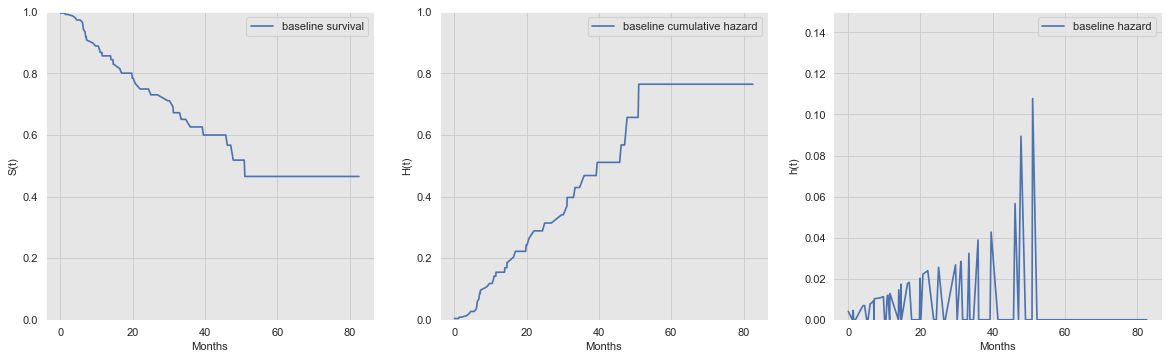

In [152]:
# Plot 3 baselines
figure=plt.figure (figsize=(18,5), dpi=80)

ax1 = plt.subplot(131)
cph_final.baseline_survival_.plot(ax=ax1) # S(t)
ax1.set(xlabel='Months', ylabel='S(t)')
ax1.set_ylim(0,1)

ax2 = plt.subplot(132)
cph_final.baseline_cumulative_hazard_.plot(ax=ax2) # H(t)=-lnS(t)
ax2.set(xlabel='Months', ylabel='H(t)')
ax2.set_ylim(0,1)

ax3 = plt.subplot(133)
cph_final.baseline_hazard_.plot(ax=ax3) # h(t)
ax3.set(xlabel='Months', ylabel='h(t)')
ax3.set_ylim(0,0.15)

The cumulative hazard H(t) has less obvious understanding than the survival functions, but the sum of estimates is much more stable than the point-wise estimates. The rate of change of this curve is an estimate of the hazard function.

In [157]:
# Visualize the impact of diagnosis on survival curves while holding everything else equal.
levels=df['diagnosis'].unique()
levels

['Meningioma', 'HG glioma', 'LG glioma', 'Other']
Categories (4, object): ['HG glioma', 'LG glioma', 'Meningioma', 'Other']

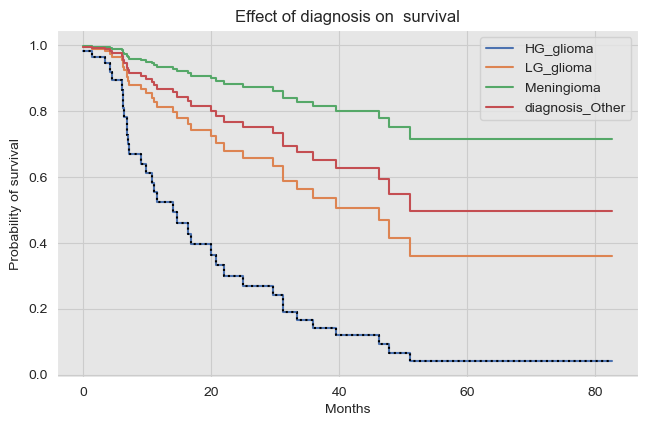

In [158]:
fig, ax=plt.subplots()
cph_final.plot_partial_effects_on_outcome(covariates=['diagnosis_LG_glioma','diagnosis_Meningioma', 'diagnosis_Other'], values=[[0,0,0],[1,0,0],[0,1,0],[0,0,1]], plot_baseline=True, ax=ax)
ax.set(xlabel='Months', ylabel='Probability of survival', title='Effect of diagnosis on  survival')
ax.legend(['HG_glioma','LG_glioma','Meningioma', 'diagnosis_Other'])
                                          
# value explain : [0,0,0]  i.e baseline level HG_Glioma =1 ,  [1,0,0] i.e LG_Glima =1 

Insights:
Plot the estimated survival curves for each diagnosis feature (4 levels), adjusting for the other predictors (internally set the values of the other predictors equal to mean for quantitative variables and equal to the mode for categorical). 

VI.7 Goodness of fit (better evaluate by both train and test set)

VI.7.2 Compute c-index score 

In [154]:
# Better evaluate model performance using test set
# c-index should be compute for train, val and test set. In this case, we have only train set
# Method 1 to compute c-index with lifelines lib
ci_train1=cph_final.score(df1, scoring_method='concordance_index')
print(f'c-index for training set: {ci_train1:.3f}')

c-index for training set: 0.789


In [155]:
# Method 2  we get the same results
ci_train2=concordance_index(df1['time'], -cph_final.predict_partial_hazard(df1), df1['status'])
print(f'c-index for training set: {ci_train2:.3f}')

c-index for training set: 0.789


Insights:
Using Concordance Index as a measure of predictive accuracy: c-index evaluates the accuracy of the relative ranking of predicted subject’s event time. It is in fact a generalization of AUC and is interpreted similarly: (0.5 is the expected result from random predictions, 1.0 is perfect concordance and,0.0 is perfect anti-concordance (multiply predictions with -1 to get 1.0)). It is scale and shift invariant (i.e. you can multiple by a positive constant, or add a constant, and the rankings won’t change). A model maximized for concordance-index does not necessarily give good predicted times, but will give good predicted rankings.Fitted survival models typically have a concordance index between 0.55 and 0.75. The final model in this study has a high c-index score 0.79.

VI.7.3 Inspect the survival probability calibration plot 

In [62]:
df1['time']

0     57.64
1      8.98
2     26.46
3     47.80
4      6.30
      ...  
83    20.69
84     6.39
85    32.82
86    42.07
87    13.90
Name: time, Length: 88, dtype: float64

[Text(0.5, 0, 'Predicted probability'),
 Text(0, 0.5, 'Fraction of positives'),
 Text(0.5, 1.0, 'Calibration plot (reliability curve)')]

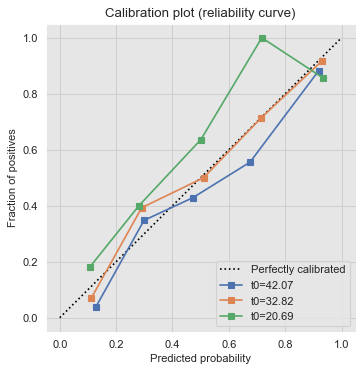

In [101]:
# Method 1  use sklearn calibration_curve, choose 3 time points
fig,ax=plt.subplots(figsize=(5,5), dpi=80)
# plot diagonal
ax.plot([0, 1], [0, 1], "k:")
# plot predited line. 
for i in [42.07, 32.82, 20.69]:
    probs = 1-np.array(cph_final.predict_survival_function(df1).loc[i])
    actual = df1['status'] 
    fraction_of_positives, mean_predicted_value = calibration_curve(actual, probs, n_bins=5) 
    ax.plot(mean_predicted_value, fraction_of_positives, "s-")
ax.legend(['Perfectly calibrated', 't0=42.07', 't0=32.82', 't0=20.69'], loc="lower right") 
ax.set(xlabel='Predicted mean',ylabel='Fraction of positives', title='Calibration plot (reliability curve)')

[Text(0.5, 0, 'Prediction Time'),
 Text(0, 0.5, 'Calibration Loss'),
 Text(0.5, 1.0, 'CoXPH Model Calibration Loss/Time')]

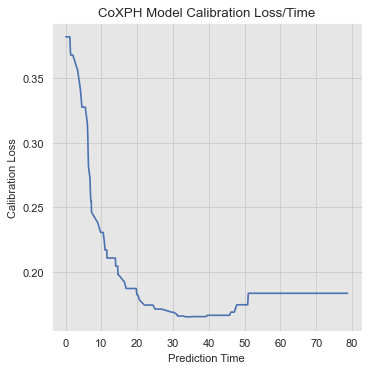

In [86]:
# brier_score_loss  
loss_dict = {} 
t0 = 82.56 #cph_final.predict_survival_function(df1).shape[0]
for i in df1[df1['time']<t0]['time']: 
    score = brier_score_loss( 
        df1['status'], 
        1-np.array(cph_final.predict_survival_function(df1).loc[i]),   
        pos_label=1) 
    loss_dict[i] = [score]  
loss_df = pd.DataFrame(loss_dict).T 

fig,ax=plt.subplots(figsize=(5,5), dpi=80)
ax=sns.lineplot(x=loss_df.index, y=list(loss_df[0])) 
ax.set(xlabel='Months', ylabel='Calibration Loss', title='CoXPH Model Calibration Loss/Time') 

c:\Users\yxm02\anaconda3\Lib\site-packages\lifelines\calibration.py:45: RuntimeWarning: divide by zero encountered in log
  return np.log(-np.log(1 - p))
c:\Users\yxm02\anaconda3\Lib\site-packages\lifelines\fitters\mixins.py:20: RuntimeWarning: invalid value encountered in subtract
  return self.relu(x - knot) ** 3 - (lambda_ * self.relu(x - min_knot) ** 3 + (1 - lambda_) * self.relu(x - max_knot) ** 3)


ICI =  0.006200371670684505
E50 =  0.007408804112479905


(<Axes: title={'center': 'Smoothed calibration curve of \npredicted vs observed probabilities of t ≤ 42 mortality'}, xlabel='Predicted probability of \nt ≤ 42 mortality', ylabel='Observed probability of \nt ≤ 42 mortality'>,
 0.006200371670684505,
 0.007408804112479905)

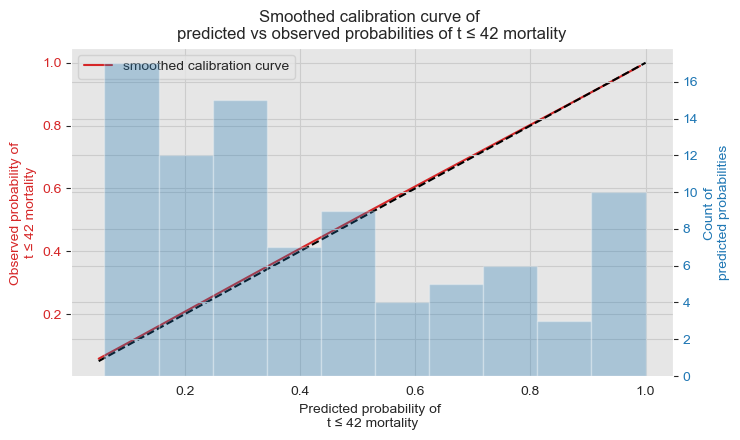

In [87]:
# Method 2  use lifelines survival_probability_calibration, plot the same 3 time points
survival_probability_calibration (cph_final, df1, t0=42.07)

c:\Users\yxm02\anaconda3\Lib\site-packages\lifelines\calibration.py:45: RuntimeWarning: divide by zero encountered in log
  return np.log(-np.log(1 - p))
c:\Users\yxm02\anaconda3\Lib\site-packages\lifelines\fitters\mixins.py:20: RuntimeWarning: invalid value encountered in subtract
  return self.relu(x - knot) ** 3 - (lambda_ * self.relu(x - min_knot) ** 3 + (1 - lambda_) * self.relu(x - max_knot) ** 3)


ICI =  0.00739634030301699
E50 =  0.0077037244945663


(<Axes: title={'center': 'Smoothed calibration curve of \npredicted vs observed probabilities of t ≤ 32 mortality'}, xlabel='Predicted probability of \nt ≤ 32 mortality', ylabel='Observed probability of \nt ≤ 32 mortality'>,
 0.00739634030301699,
 0.0077037244945663)

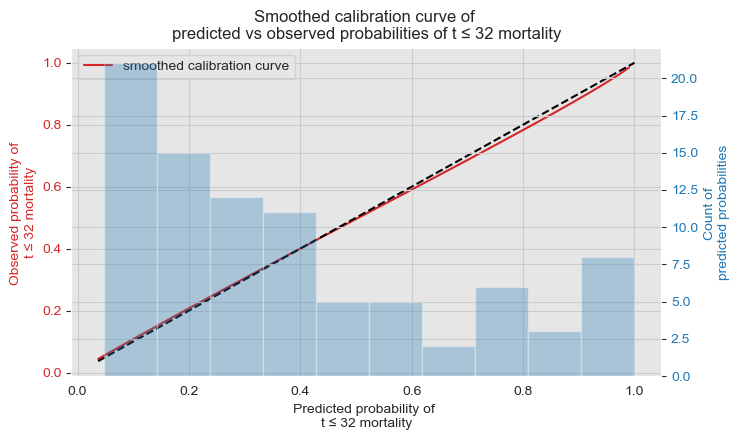

In [89]:
survival_probability_calibration (cph_final, df1, t0=32.82)

c:\Users\yxm02\anaconda3\Lib\site-packages\lifelines\calibration.py:45: RuntimeWarning: divide by zero encountered in log
  return np.log(-np.log(1 - p))
c:\Users\yxm02\anaconda3\Lib\site-packages\lifelines\fitters\mixins.py:20: RuntimeWarning: invalid value encountered in subtract
  return self.relu(x - knot) ** 3 - (lambda_ * self.relu(x - min_knot) ** 3 + (1 - lambda_) * self.relu(x - max_knot) ** 3)


ICI =  0.026904468783041854
E50 =  0.019179218571422352


(<Axes: title={'center': 'Smoothed calibration curve of \npredicted vs observed probabilities of t ≤ 20 mortality'}, xlabel='Predicted probability of \nt ≤ 20 mortality', ylabel='Observed probability of \nt ≤ 20 mortality'>,
 0.026904468783041854,
 0.019179218571422352)

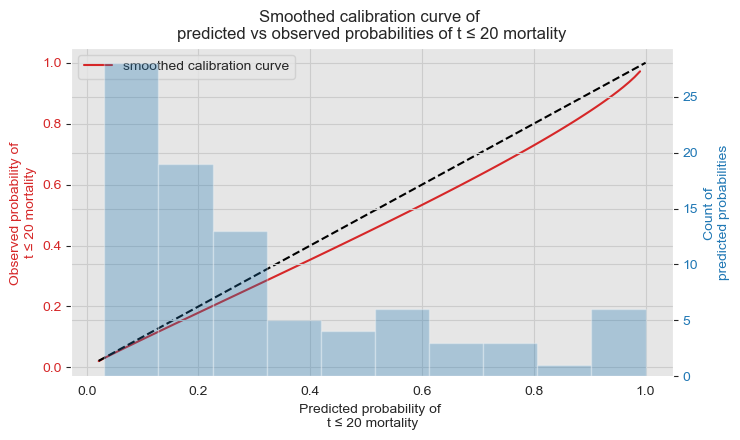

In [88]:
survival_probability_calibration (cph_final, df1, t0=20.69)

Insights: 
Calibration curve measures our model's prediction P(T<t0) against observed frequencies of events. 
ICI: mean absolute difference bw predicted and observed 
E50: median absolute difference bw predicted and observed 

For the 3 time points chosen, good agreement between predicted and observed outcomes are observed. From brier_score_loss figure, we see calibration improves as the time increase. 

At t0=20.69, survival_probability_calibration displayed overestimation by the model (redline is under perfect calibration); but the calibration_curve showed underestimation (green line is above the perfect calibration line)(??)

VI.7.1 Test PH assumption (must be the  first evaluation)


   Bootstrapping lowess lines. May take a moment...




   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


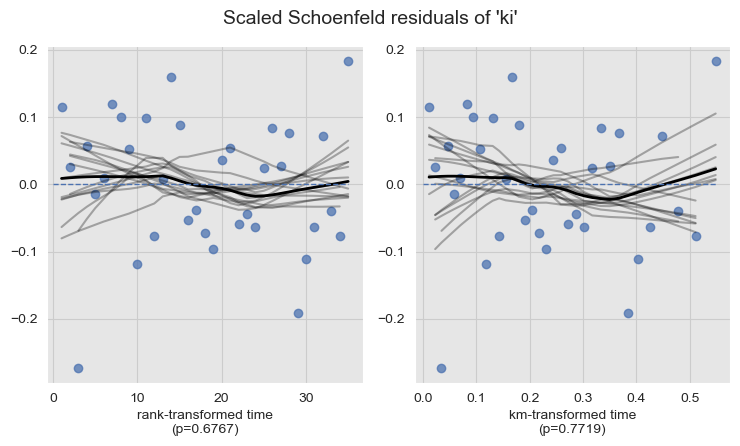

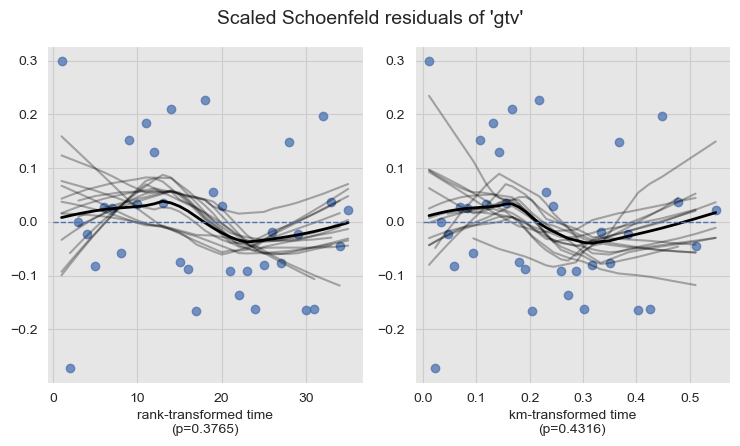

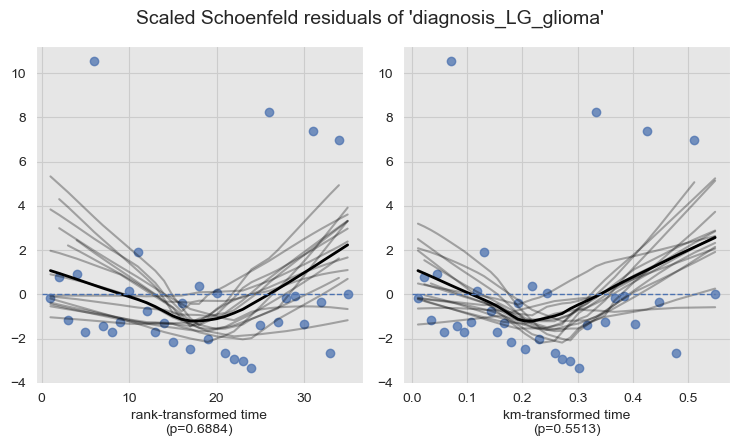

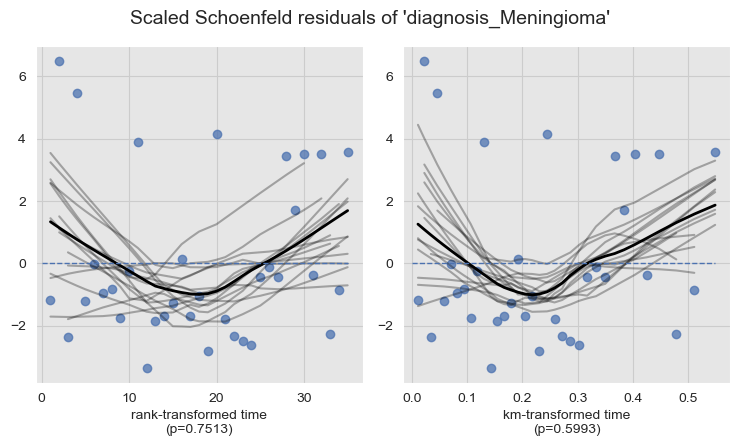

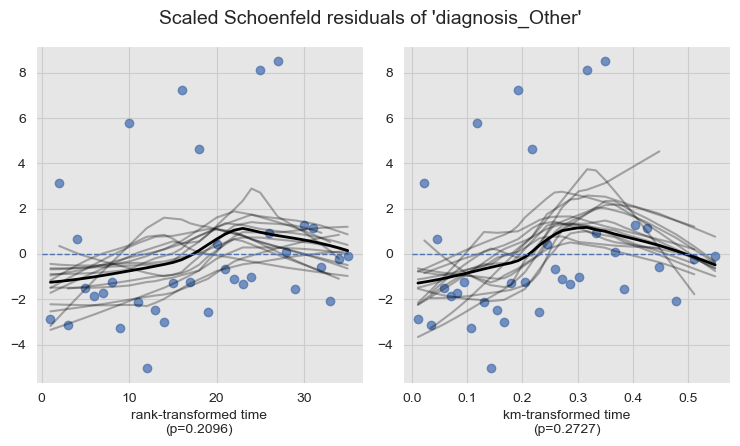

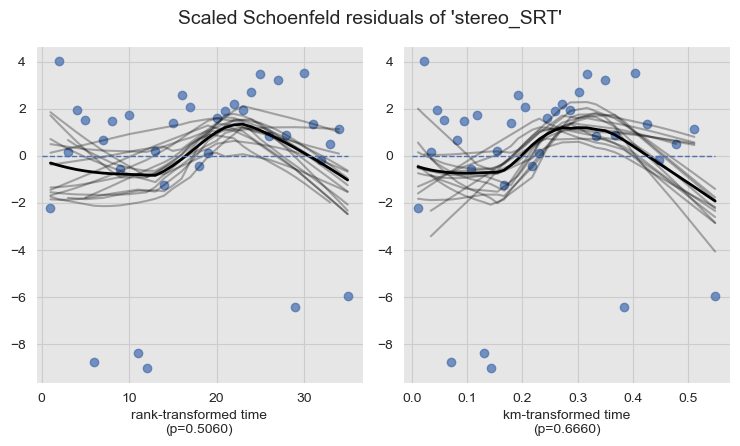

In [124]:
# Method 1 
result1=cph_final.check_assumptions(df1, p_value_threshold=0.05, show_plots=True )

Insights: 
The aim is to test any time-varying coefficients. A time-varying coefficient imply a covariate influence relative to the baseline changes over time. This implies a violation of the proportional hazard assumption. For each variable, lifelines transform time four times (these are common transformations of time to perform). We reject the null (the coefficient is not time-varying) if the p-values <0.05 setting the significant level at 0.05.

In this test, all p values > 0.05, can't reject null hypothesis. Visually, from the plots of the scaled Schoenfeld residuals over time (or some transform of time) for each feature, we see E[St,j]=0 (all lines are constant at 0), indicating no violations of PH assumption.

In [156]:
# Method 2 to compute the test. Conclusion likes the first one, no time varying feature found.
results = proportional_hazard_test(cph_final, df1, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 88 total observations, 53 right-censored observations>
         test_name = proportional_hazard_test

---
                      test_statistic    p  -log2(p)
diagnosis_LG_glioma             0.26 0.61      0.72
diagnosis_Meningioma            0.04 0.83      0.26
diagnosis_Other                 1.05 0.31      1.71
gtv                             0.37 0.54      0.88
ki                              0.15 0.70      0.51

VI.8 Use the final model to predict

In [103]:
# Take the first 5 patients as examples to perform prediction
pd.DataFrame(df1.loc[0:4])

,ki,gtv,status,time,sex_Male,diagnosis_LG_glioma,diagnosis_Meningioma,diagnosis_Other,loc_Supratentorial,stereo_SRT
0,90,6.11,0,57.64,0,0,1,0,0,0
1,90,19.35,1,8.98,1,0,0,0,1,1
2,70,7.95,0,26.46,0,0,1,0,0,0
3,80,7.61,1,47.80,0,1,0,0,1,1
4,90,5.06,1,6.30,1,0,0,0,1,1


In [104]:
X_to_pred=pd.DataFrame(df1.loc[0:4][['ki', 'gtv', 'diagnosis_LG_glioma','diagnosis_Meningioma', 'diagnosis_Other','stereo_SRT']])
X_to_pred

,ki,gtv,diagnosis_LG_glioma,diagnosis_Meningioma,diagnosis_Other,stereo_SRT
0,90,6.11,0,1,0,0
1,90,19.35,0,0,0,1
2,70,7.95,0,1,0,0
3,80,7.61,1,0,0,1
4,90,5.06,0,0,0,1


In [106]:
# Prediction for individual: partial hazard, median lifetimes for the individuals, percentile lifetimes
print(cph_final.predict_partial_hazard(X_to_pred), '\n\n')
print(cph_final.predict_median(X_to_pred), '\n\n')
print(cph_final.predict_percentile(X_to_pred, 0.9))

0    0.247805
1    4.122126
2    0.800368
3    1.397770
4    2.268908
dtype: float64 


0      inf
1    14.00
2      inf
3    39.54
4    25.02
Name: 0.5, dtype: float64 


0    33.41
1     4.56
2    11.02
3     6.92
4     6.30
Name: 0.9, dtype: float64


Insights:
It’s important to remember that this is now computing a conditional probability (or metric), so if the result of predict_median is 10.5, then the entire lifetime is 10.5 + conditional_after. conditional_after=censored_subjects_last_obs
If using conditional_after to predict on uncensored subjects, then conditional_after should probably be set to 0, or left blank.

In [107]:
#Predict the survival function for individuals, given their covariates.
print(cph_final.predict_survival_function(X_to_pred), '\n\n')
#cumulative hazard
print(cph_final.predict_cumulative_hazard(X_to_pred))

              0         1         2         3         4
0.07   0.998988  0.983301  0.996736  0.994306  0.990774
1.18   0.998988  0.983301  0.996736  0.994306  0.990774
1.41   0.997865  0.965069  0.993120  0.988016  0.980620
1.54   0.997865  0.965069  0.993120  0.988016  0.980620
2.03   0.997865  0.965069  0.993120  0.988016  0.980620
...         ...       ...       ...       ...       ...
65.02  0.827349  0.042736  0.542188  0.343334  0.176344
67.38  0.827349  0.042736  0.542188  0.343334  0.176344
73.74  0.827349  0.042736  0.542188  0.343334  0.176344
78.75  0.827349  0.042736  0.542188  0.343334  0.176344
82.56  0.827349  0.042736  0.542188  0.343334  0.176344

[86 rows x 5 columns] 


              0         1         2         3         4
0.07   0.001012  0.016840  0.003270  0.005710  0.009269
1.18   0.001012  0.016840  0.003270  0.005710  0.009269
1.41   0.002137  0.035555  0.006904  0.012056  0.019570
1.54   0.002137  0.035555  0.006904  0.012056  0.019570
2.03   0.002137  0.035

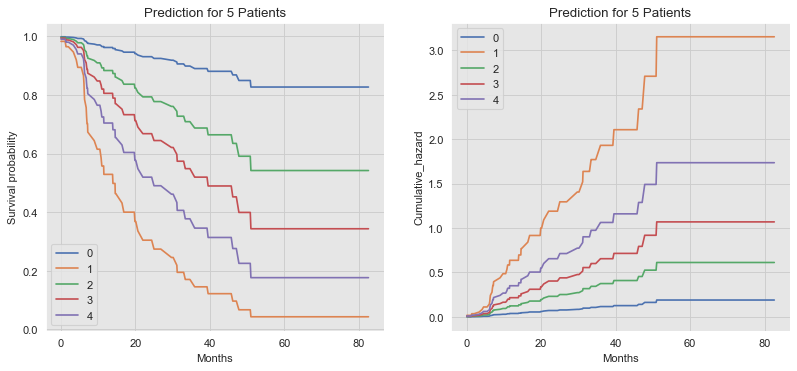

In [175]:
# H(t)=-logS(t) = integral (0, t) h(t)
figure=plt.figure (figsize=(12,5), dpi=80)

ax1 = plt.subplot(121)
cph_final.predict_survival_function(X_to_pred).plot(ax=ax1)
ax1.set(xlabel='Months', ylabel='Survival probability', title='Prediction for 5 Patients', )
ax1.legend(list(X_to_pred.index))

ax2 = plt.subplot(122)
cph_final.predict_cumulative_hazard(X_to_pred).plot(ax=ax2)
ax2.set(xlabel='Months', ylabel='Cumulative_hazard', title='Prediction for 5 Patients', )
ax2.legend(list(X_to_pred.index))


## VII Conslusion

Work done:

Main findings:....(summarize main observations)

Difficulty:

Outlook for this analysis:
- Train test split
- Regularization in linear regression 
- Add time varying features, built time dependant PH model
- Can try parametric model as well
- Collect more data

In [6]:
# kfold=KFold(n_splits=5, random_state=0, shuffle=True)
# grid=GridSearchCV(estimator=CoxPHFitter(l1_ratio=1.0), param_grid={'penalize': [0.001, 0.01, 0.1, 1, 5, 10, 100]}, cv=kfold, refit=True, scoring='concordance_index')
# grid.fit(df1, duration_col='time', event_col='status')
# ref.
# https://aistudio.baidu.com/projectdetail/3410026
# https://lifelines.readthedocs.io/en/latest/index.html
# https://cloud.tencent.com/developer/article/1913791